# Measure angle of wall in front of TMF8820/21/28 to allow keystone correction in a projector application

Script runs interactively and connects to the [TMF8820/21/28 EVM](https://ams-osram.com/products/boards-kits-accessories/kits/ams-tmf882x-evm-db-demo-evaluation-kit)

![application_running.png](./application_running.png)

Howto execute:
1. You need to have Python3 installed; inside Python3 it needs matplotlib library installed
2. EVM of [TMF882X](https://ams-osram.com/products/boards-kits-accessories/kits/ams-tmf882x-evm-db-demo-evaluation-kit) installed and running before starting the script
3. Double click 'keystone.py' or execute 'keystone.ipynb' in a JupyterLab environment

Operation:
- Hold the EVM in front of a wall
- Rotate the EVM along its vertical or lateral axis and you should see the 3d View representing the EVM being rotated in sync with the rotation of the EVM

Documentation:
- README.md or keystone.ipynb


## Measure angle of wall facing TMF8820/TMF8821
![math.drawio.png](./math.drawio.png)

and use 3x3 mode

### We have
b, c and $\alpha$  
c = distance of center zone  
b = distance of edge zone  
$\alpha$ defined by SPAD map - angle between center zone and edge zone

### We want
$\phi$

### Calculation
Calculate a with <https://www.arndt-bruenner.de/mathe/10/kosinussatz.htm>

$a^2 = b^2 + c^2 – b c \cos \alpha$

$a = \sqrt{ b^2 + c^2 – b c \cos \alpha} $

Apply sinussatz <https://de.wikipedia.org/wiki/Sinussatz>

$\frac{a}{\sin \alpha} = \frac{c}{\sin \beta} = \frac{b}{\sin \gamma }$

$\frac{b}{\sin \gamma} = \frac{a}{\sin \alpha }$

$\frac{\sin \gamma }{b} = \frac{\sin \alpha}{a}$

$\sin \gamma = \frac{b \sin \alpha }{a}$

$\gamma = \arcsin \frac{b \sin \alpha }{a} $

$\phi = 90^\circ - \gamma$  

In [1]:
# *****************************************************************************
# Copyright (c) [2024] ams-OSRAM AG                                           *
# All rights are reserved.                                                    *
#                                                                             *
# FOR FULL LICENSE TEXT SEE LICENSE.TXT                                       *
# *****************************************************************************
#
# Version 1v1
# ptr / 23.Oct 2024

In [2]:
import math
import socket 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec


def calc_angle(center, edge, alpha):
    '''
    Calculate angle of triangle to a perpendicular wall where

    alpha = anlge between dist1 and dist2 (defined by SPAD mask) in degrees
    center = distance of center zone in [mm]
    edge = distance of edge zone in [mm]

    returns angle in degrees (not radians)
    '''
    try:
        # apply law of cosines to get third length of triangle
        a = math.sqrt(center**2 + edge**2 
                      - 2 * center * edge * math.cos(math.radians(alpha)))
        # apply law of sines to calculate angles in triangle
        gamma = math.degrees(math.asin(edge / a * math.sin(math.radians(alpha))))
        phi = 90 - gamma
        # note: asin is ambiguous - cannot check if we are above or below perpendicular
        # check this wiht pythagoras
        if edge**2 > center**2 + a**2:
            phi = -phi
        return (phi)
    except ZeroDivisionError:
        return (0)

In [3]:
# test function
# for i in range (100, 120):
#     print (f'center=100mm edge={i}mm angle={calc_angle(100, i, 20):6.1f}deg')

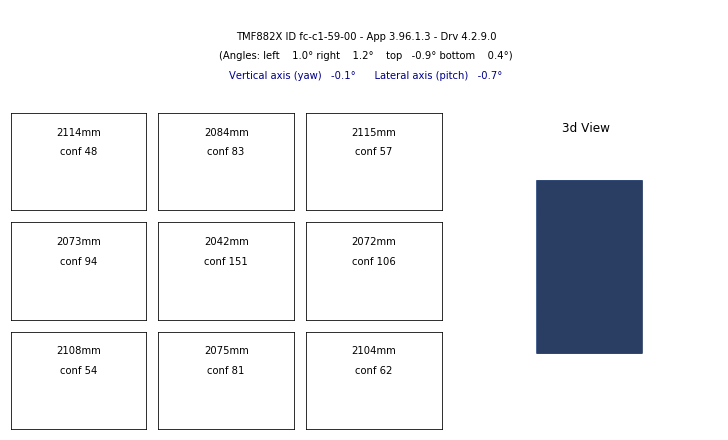

In [4]:
tof_id = None # tof unique ID


def get_data_from_EVM_GUI(sock) -> (str, int, int, int, int):
    '''Process information from TMF882X EVM GUI and extract data as needed

    sock -- an open socket for the connection to the EVM GUI; connection errors need to be handled in calling function

    return value: (description, xtalk)
    string description -- a textual description for displaying the result or any error
    int xtalk -- integer with amount of crosstalk; returns 0 in case of error
    int background -- the amount of background light, should be much lower than xtalk
    int iterations -- number of iterations for this measurement
    obj -- object data; array of integers of distance / confidence for each ch
    '''
    xtalk = [0]*10  # initialize
    background = [0]*10
    iterations = 0
    obj = None  # initialize
    sock.sendall(b'(m0)')  # run measurement command 'm'
    while True:
        global tof_id
        try:
            s = str(sock.recv(10000), 'utf-8')
            entries = s.split('\r\n')  # we could have read several lines, so process them one by one
            for item in entries:
                try:
                    data = item.split(';')
                    if data[0] == '#VER':
                        tof_id = f'TMF882X ID {data[1]} - App {data[2]} - Drv {data[3]}'
                    if data[0][0:6] == '#HLONG':  # histograms
                        # do whatever needs to be done with histograms... only an example is shown below
                        entry = int(data[0][7]) # which histogram?
                        pt_hist = [int(x) for x in data[1:]]  # convert to int list
                        xtalk[entry] = max(pt_hist[5:20])  # search for the crosstalk peak
                        # background light calculation: max(avg bins 0-8)
                        background[entry] = sum(pt_hist[0:8])/8
                    if data[0] == '#OBJ':  # OBJ is always the last entry
                        obj = [int(x) for x in data[5:]]  # convert to int list removing other information
                        return (f'XTalk {xtalk} BG {background}', xtalk, background, iterations, obj)
                    if data[0] == '#ITT':  # iterations
                        iterations = int(data[2])
                except (ValueError, IndexError) as e:
                    pass  # to ignore header lines as they raise an exception if converted to int()
        except socket.timeout:
            tof_id = ''
            return('No device connected', 0, 0, 0, None)


def pick_best(obj):
    '''Check if there is a second target and use this if it has higher confidence'''
    if obj[1] > obj[3]:  # compare confidence first/second target
        return obj[0]  # return first target
    else:
        return obj[2]  # return second target1


def animate(i, axs, sock): 
    description, xtalk, background, iterations, obj = get_data_from_EVM_GUI(sock)
    for i in range(10):
        axs[i].clear()
        axs[i].set_xticks([])  # hide axes
        axs[i].set_yticks([])  # hide axes
    ax_info = axs[9]
    ax_info.set(frame_on=False)
    ax3d = axs[10]
    ax3d.axis('off')
    ax3d.set_xlim(-1.5, 2.5)
    ax3d.set_ylim(-0.2, 1.2)
    if obj:
        try:
            for i in range(9): # iterate over zones
                index = i*4  # index into objects
                if (obj[index]>0):
                    axs[i].annotate(f'{obj[index]}mm', (0.5, 0.8), ha='center', va='center')   # distance
                    axs[i].annotate(f'conf {obj[index+1]}', (0.5, 0.6), ha='center', va='center') # confidence
                if (obj[index+2]>0):  # second object?
                    axs[i].annotate(f"{obj[index+2]}mm", (0.5, 0.4), ha='center', va='center')   # distance
                    axs[i].annotate(obj[index+3], (0.5, 0.2), ha='center', va='center') # confidence   
#                # add background and crosstalk
#                axs[i].annotate(f'xtalk {xtalk[i+1]}', (0.5, 0.4), ha='center', va='center')
#                axs[i].annotate(f'ambient bg. {int(background[i+1])}', (0.5, 0.2), ha='center', va='center')

            # now fill the information frame
            angle_zone_left_right = 33/3 # angle between center and left / right zone in degrees
            angle_zone_up_down = 32/3    # angle between center and up / down zone in degrees

            center = pick_best(obj[4*4:])
            top = pick_best(obj[1*4:])
            bottom = pick_best(obj[7*4:])
            left = pick_best(obj[3*4:])
            right = pick_best(obj[5*4:])

            top_angle = calc_angle(center, top, angle_zone_up_down)
            bottom_angle = calc_angle(center, bottom, angle_zone_up_down)
            left_angle = calc_angle(center, left, angle_zone_left_right)
            right_angle = calc_angle(center, right, angle_zone_left_right)
            ax_info.annotate(tof_id, (0.5, 0.7), ha='center', va='center')
            #ax_info.annotate(f' Distances top {top} left {left} center {center} right {right} bottom {bottom}',
            #                 (0.1, 0.5), ha='left', va='center')
            text_color = 'darkblue'
            max_angle_deviation = 15
            if (top_angle + bottom_angle > max_angle_deviation) or (left_angle + right_angle > max_angle_deviation):
                text_color = 'red'
            ax_info.annotate(f'(Angles: left {left_angle:6.1f}° right {right_angle:6.1f}°    top {top_angle:6.1f}° bottom {bottom_angle:6.1f}°)',
                             (0.5, 0.5), ha='center', va='center')
            ax_info.annotate(f'Vertical axis (yaw) {(left_angle-right_angle)/2:6.1f}°      Lateral axis (pitch) {(top_angle-bottom_angle)/2:6.1f}°',
                             (0.5, 0.3), ha='center', va='center', color=text_color)
            # now show 3d animation
            ax3d.bar3d([0], [0], [0], [1], [1], [1], shade=True, color='cornflowerblue')
            ax3d.view_init(elev=(top_angle-bottom_angle)/2, azim=(right_angle-left_angle)/2)

        except IndexError:
            pass   # ignore it...
    else:
        ax_info.annotate('No Device Connected', (0.1, 0.5), ha='left', va='center', color='red')


global ani
ani  = None  # need to define global to avoid closing animation
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM) 
host = "localhost"  # the EVM GUI should be run on the same computer
port = 39998  # ToF EVM Automation port 

try:
    sock.connect((host, port))
    sock.settimeout(1)  # 1s timeout
    sock.sendall(b'(i4000)') # 4 M iterations
    # fig, axs = plt.subplots(3, 3, figsize=(7, 5)) # create figure
    fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    spec = gridspec.GridSpec(ncols=5, nrows=4, figure=fig)
    axs = [None]*11  # reserve array
    for i in range(9):
        axs[i] = fig.add_subplot(spec[int(i/3) + 1, i % 3])
    axs[9] = fig.add_subplot(spec[0, :])  # information row - spans whole first row
    axs[10] = fig.add_subplot(spec[1:, -2:], projection='3d') # 3d view; last column
    axs[10].set_title('3d View')

    animate(0, axs, sock) # first call to see if we have errors

    ani = animation.FuncAnimation(fig, animate, fargs=[axs, sock], interval=300)
    plt.show()

except socket.error as e:
    print(f'Please start TMF882X EVM GUI and connect TMF882X before starting this script - Connection Error: {e}')
    input('Press enter to quit')

# need to close sock when animnation is finished
sock.close()